Use conda environment `conda_envs/hic_nikita.yml` to run this notebook.

In [1]:
import sys
sys.path.append('scripts')

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Some additional for plots
import matplotlib as mpl
from matplotlib.lines import Line2D
from matplotlib.colors import LogNorm
import matplotlib.patches as mpatches
from matplotlib.ticker import AutoMinorLocator, MultipleLocator

import cooler # Hi-C data processing
import networkx as nx # Network analysis
import pingouin as pg # Statistics

# Some utils for notebook
from tqdm import tqdm
from IPython.display import display

# Custom
import my_loops_module
from my_loops_module import *
from my_network_utils import *

/home/nvaulin/tools/mambaforge/envs/hic-env/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [5]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

# Input data:

- `/tank/projects/tian2023/cells_fullmeta_m3C.tsv` - snm3C-seq metadata from *Tian et al., 2023* 
- `data/polycomb_dots_hand_coords_update_June25.tsv` - Polycomb dot coordinates identified in this paper
- `data/polycomb_dots_intensities_pad10kb_EN_IN_NN.csv` - Polycomb dot intensities identified in this paper (in notebook *code/Loops_vs_Expression/2_Get_sc_loops_intensities.ipynb*)

Not in the repository:
- `data/polycomb_loop_clusters_update_June25.tsv` - this paper, from notebook *4_Heatmaps_by_CellType_and_MajorType.ipynb*
- `data/pcg_loops_groupedMaJType_norm_whole_update_June25.pkl` - this paper, from notebook *4_Heatmaps_by_CellType_and_MajorType.ipynb*



In [ ]:
data_dir = '../../data/'

In [6]:
tian_wd = '/tank/projects/tian2023/'
m3C_meta = pd.read_csv(os.path.join(tian_wd, 'cells_fullmeta_m3C.tsv'), sep='\t', index_col=0)
m3C_meta = m3C_meta.query('Cool_name != "GSM7346586_HBA_220615_H1930004_CX46_SEP_3C_2_P1-4-B11-M20.cool"')

In [9]:
pcg_sc_loops_meta_norm_grouped = pd.read_pickle(data+'pcg_loops_groupedMaJType_norm_whole_update_June25.pkl')
preds = pd.read_csv(data + 'polycomb_loop_clusters_MajType_update_June25.tsv', index_col=0)
loops_clusters = preds.set_index('loop')[['cluster_name', 'cluster_id']]

In [7]:
from pandas.api.types import CategoricalDtype
regions_groups = {
    'Basal Nuclei': ['AMY', 'CMN', 'CaB', 'GPe', 'BNST', 'NAC', 'Pu'],
    'Basal Forebrain': ['SI', 'SEP'],
    'Cerebral cortex': ['MTG', 'LEC', 'A24', 'A46', 'FI', 'M1C', 'V1C', 'Pir']
}

regions_order = [reg for regs in regions_groups.values() for reg in regs]
reg_type = CategoricalDtype(categories=regions_order, ordered=True)
ct_type = CategoricalDtype(categories=['EN' , 'IN', 'NN'], ordered=True)
chr_type = CategoricalDtype(categories=chroms, ordered=True)


ct_palette = {"EN": "#3924B1",
              "IN": "#C1118C",
              "NN": "#ffc875"}

def get_chr(loop_coords):
    chr1 = loop_coords[0][0]
    chr2 = loop_coords[1][0]
    return chr1 if chr1 == chr2 else 'trans'

chroms_colors = {chroms[i] : plt.get_cmap('tab20b')((i+1) / len(chroms)) for i in range(len(chroms[:-1])) }
chroms_colors['trans'] = (0,0,0)

In [8]:
major_types_to_celltype = m3C_meta[['MajorType', 'CellClass']].drop_duplicates().set_index('MajorType').CellClass.to_dict()

In [11]:
from sklearn.decomposition import PCA

maj_types = pcg_sc_loops_meta_norm_grouped.index.to_series()
dots_colors = maj_types.map(major_types_to_celltype).map(ct_palette).values

In [12]:
pca = PCA(n_components=4)
pca_result = pca.fit_transform(pcg_sc_loops_meta_norm_grouped)
explained_variance = pca.explained_variance_ratio_ * 100  # Convert to percentage

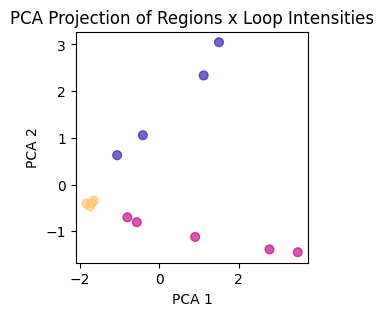

In [13]:
plt.figure(figsize=(3, 3))
plt.scatter(pca_result[:, 0], pca_result[:, 1], 
            c=dots_colors,
            s=40, alpha=0.7)
plt.title('PCA Projection of Regions x Loop Intensities')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

In [14]:
import re

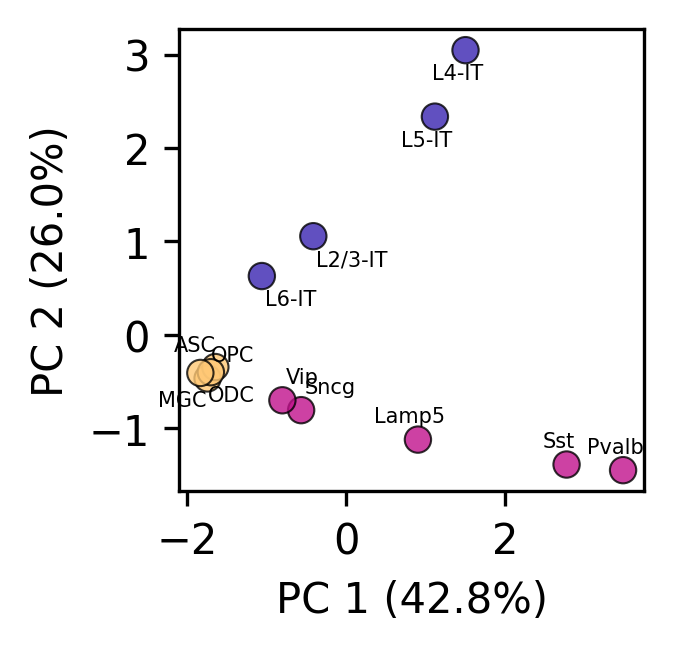

In [17]:
plt.figure(figsize=(2, 2), dpi=300)
plt.scatter(pca_result[:, 0], pca_result[:, 1], 
            c=dots_colors, edgecolor='k', linewidth=0.5,
            s=40, alpha=0.8)

for i in range(len(pca_result)):
    x, y, t = pca_result[i, 0], pca_result[i, 1], maj_types[i]
    # if x <-0.4 and y<0.1:
    #     continue
    ha = 'center' if x > 0.4 else 'left'
    px = -0.1 if x > 0.4 else 0.04
    py = -0.25 if y > 0 else 0.25
    match t:
        case 'MGC':
            px=-0.05
            py=-0.3
            ha='right'
        case 'ODC':
            px=+0.5
            py=-0.3
            ha='right'
        case 'ASC':
            px=0.2
            py=0.3
            ha='right'
    plt.text(x+px, y+py, t,
             fontsize=5, ha=ha, va='center')


# Add explained variance to axis labels
plt.xlabel(f'PC 1 ({explained_variance[0]:.1f}%)')
plt.ylabel(f'PC 2 ({explained_variance[1]:.1f}%)')


# plt.savefig('imgs/Fig2A_PCA_by_CellType.pdf', bbox_inches='tight')
plt.show()

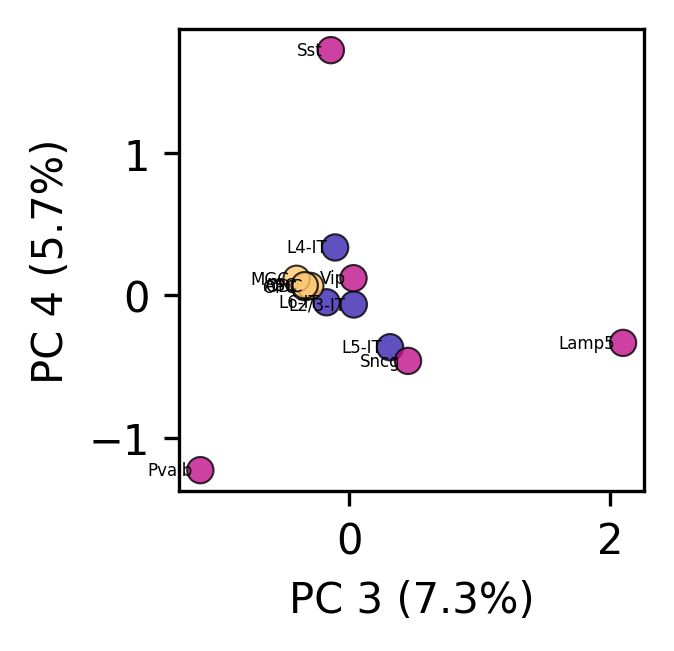

In [19]:
plt.figure(figsize=(2, 2), dpi=300)
plt.scatter(pca_result[:, 2], pca_result[:, 3], 
            c=dots_colors, edgecolor='k', linewidth=0.5,
            s=40, alpha=0.8)

for i in range(len(pca_result)):
    plt.text(pca_result[i, 2]-.06, pca_result[i, 3], maj_types[i], 
             fontsize=4, ha='right', va='center')

# Add explained variance to axis labels
plt.xlabel(f'PC 3 ({explained_variance[2]:.1f}%)')
plt.ylabel(f'PC 4 ({explained_variance[3]:.1f}%)')

plt.show()

In [20]:
loadings = pd.DataFrame(
    pca.components_.T,  # Transpose so features are rows, PCs are columns
    columns=[f'PC{i + 1}' for i in range(pca.n_components_)],
    index=pcg_sc_loops_meta_norm_grouped.columns  # Feature names
)

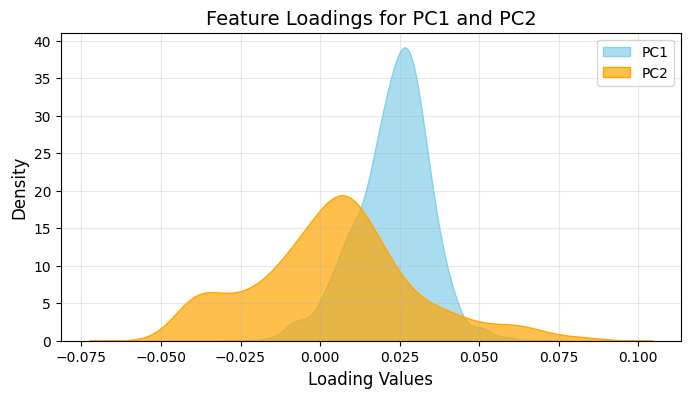

In [42]:
plt.figure(figsize=(8, 4))
sns.kdeplot(loadings['PC1'], label='PC1', fill=True, color='skyblue', alpha=0.7)
sns.kdeplot(loadings['PC2'], label='PC2', fill=True, color='orange', alpha=0.7)

# Add labels, title, and legend
plt.title('Feature Loadings for PC1 and PC2', fontsize=14)
plt.xlabel('Loading Values', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)


# plt.savefig('imgs/FigS2B_PCA_Loadings_by_CellType.pdf', bbox_inches='tight')
plt.show()

In [23]:
loadings.to_csv(data + 'Polycomb_Loops_PCA_Loadings_Tian.csv.csv')
loadings

,PC1,PC2,PC3,PC4
"(('chr1', 18630000, 18640000), ('chr1', 24930000, 24940000))",0.031091,0.002427,0.006069,-0.011894
"(('chr1', 18630000, 18640000), ('chr1', 44410000, 44420000))",0.026096,0.004445,0.022510,0.006290
"(('chr1', 18630000, 18640000), ('chr1', 46480000, 46490000))",0.027514,-0.013744,0.019179,-0.021016
"(('chr1', 18630000, 18640000), ('chr1', 47180000, 47250000))",0.022363,-0.005102,0.013205,-0.001363
"(('chr1', 18630000, 18640000), ('chr1', 47430000, 47440000))",0.026569,0.010145,0.028585,0.030784
...,...,...,...,...
"(('chr20', 21085000, 21115000), ('chr20', 38710000, 38730000))",0.008711,0.065579,0.005045,-0.012040
"(('chr20', 21380000, 21410000), ('chr20', 38710000, 38730000))",0.014278,0.075626,0.011238,0.007615
"(('chr20', 21500000, 21525000), ('chr20', 38710000, 38730000))",0.007251,0.066720,0.011882,-0.010107
"(('chr20', 22560000, 22590000), ('chr20', 38710000, 38730000))",0.013145,0.066798,-0.006937,-0.011604


## Add genes

In [27]:
# polycomb_dots = pd.read_csv(data + 'polycomb_dots_hand_coords_update_June25.tsv', sep='\t', index_col=0).set_index('contact_pair')
# polycomb_dots['genes'] = polycomb_dots['gene1'] + ' <-> ' + polycomb_dots['gene2']
# loadings.index = loadings.index.to_series().apply(str)
# loadings = loadings.join(polycomb_dots[['genes', 'gene1', 'gene2']])